In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from qlstm_pennylane import QLSTM
import pandas as pd

In [5]:
df_half_hour=pd.read_csv('completed data.csv')
df_half_hour.isna().sum()

station       0
valid         0
lon           0
lat           0
elevation     0
relh          0
drct          0
sknt          0
alti          0
vsby          0
metar         0
temp_c        0
dewpoint_c    0
feel_c        0
dtype: int64

In [6]:
colums=['elevation','station','lon','lat','metar']
filter_df=df_half_hour.drop(columns=colums)
filter_df

,valid,relh,drct,sknt,alti,vsby,temp_c,dewpoint_c,feel_c
0,1/1/2010 0:00,72.20,170.0,3.0,30.09,3.73,16.0,11.0,16.0
1,1/1/2010 0:30,72.20,170.0,3.0,30.09,1.86,16.0,11.0,16.0
2,1/1/2010 1:00,72.20,150.0,4.0,30.09,1.24,16.0,11.0,16.0
3,1/1/2010 1:30,72.20,150.0,4.0,30.09,1.24,16.0,11.0,16.0
4,1/1/2010 2:00,76.98,150.0,8.0,30.09,1.24,15.0,11.0,15.0
...,...,...,...,...,...,...,...,...,...
260713,10/21/2024 21:30,56.63,50.0,8.0,30.09,6.21,22.0,13.0,22.0
260714,10/21/2024 22:00,56.63,40.0,10.0,30.09,6.21,22.0,13.0,22.0
260715,10/21/2024 22:30,56.63,40.0,7.0,30.12,6.21,21.0,13.0,22.0
260716,10/21/2024 23:00,60.21,30.0,7.0,30.09,6.21,21.0,13.0,21.0


In [7]:
# Ensure the 'valid' column is in datetime format
filter_df['valid'] = pd.to_datetime(filter_df['valid'])

# Add a 'date' column for easier grouping
filter_df['date'] = filter_df['valid'].dt.date

# Find rows with the maximum temperature for each day
daily_max_temp = filter_df.loc[filter_df.groupby('date')['temp_c'].idxmax()].reset_index(drop=True)

# Inspect the result
daily_max_temp.drop(columns=['valid'],inplace=True)
daily_max_temp


,relh,drct,sknt,alti,vsby,temp_c,dewpoint_c,feel_c,date
0,41.42,200.0,4.0,30.060,6.21,25.0,11.0,25.000000,2010-01-01
1,33.85,230.0,11.0,30.000,1.86,25.0,8.0,24.438889,2010-01-02
2,53.03,280.0,4.0,30.030,6.21,22.0,12.0,22.000000,2010-01-03
3,59.97,280.0,5.0,30.090,6.21,20.0,12.0,20.000000,2010-01-04
4,49.37,40.0,11.0,30.090,6.21,21.0,10.0,21.000000,2010-01-05
...,...,...,...,...,...,...,...,...,...
5402,41.19,330.0,8.0,29.925,6.21,29.0,14.5,28.719444,2024-10-17
5403,42.52,10.0,7.0,29.880,6.21,29.0,15.0,28.844444,2024-10-18
5404,39.58,30.0,9.0,29.970,6.21,28.0,13.0,27.638889,2024-10-19
5405,34.69,40.0,18.0,30.060,6.21,28.0,11.0,27.333333,2024-10-20


In [8]:
percentile_90 = np.percentile(daily_max_temp['temp_c'], 90)
print(f"90th Percentile of max_temp_c: {percentile_90}")
daily_max_temp

90th Percentile of max_temp_c: 36.0


,relh,drct,sknt,alti,vsby,temp_c,dewpoint_c,feel_c,date
0,41.42,200.0,4.0,30.060,6.21,25.0,11.0,25.000000,2010-01-01
1,33.85,230.0,11.0,30.000,1.86,25.0,8.0,24.438889,2010-01-02
2,53.03,280.0,4.0,30.030,6.21,22.0,12.0,22.000000,2010-01-03
3,59.97,280.0,5.0,30.090,6.21,20.0,12.0,20.000000,2010-01-04
4,49.37,40.0,11.0,30.090,6.21,21.0,10.0,21.000000,2010-01-05
...,...,...,...,...,...,...,...,...,...
5402,41.19,330.0,8.0,29.925,6.21,29.0,14.5,28.719444,2024-10-17
5403,42.52,10.0,7.0,29.880,6.21,29.0,15.0,28.844444,2024-10-18
5404,39.58,30.0,9.0,29.970,6.21,28.0,13.0,27.638889,2024-10-19
5405,34.69,40.0,18.0,30.060,6.21,28.0,11.0,27.333333,2024-10-20


In [9]:
daily_max_temp=daily_max_temp.drop(columns=['date'])

# Some functions needed

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam  # Import the Adam optimizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Normalize data
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Create sequences for training/testing
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])  # (sequence_length, 8)
        labels.append(data[i + sequence_length])  # Keep next step as (8,)
    return np.array(sequences), np.array(labels)  # Now, labels will have shape (num_samples, 8)


import torch
import torch.nn as nn

# Function to build and return a classical LSTM model in PyTorch
def build_lstm_model(input_dim, hidden_dim=50, output_dim=None, learning_rate=0.001):
    output_dim = output_dim if output_dim else input_dim
    
    # Define the model
    class ClassicalLSTM(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(ClassicalLSTM, self).__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
            self.fc = nn.Linear(hidden_dim, output_dim)
        
        def forward(self, x):
            lstm_out, _ = self.lstm(x)  # x shape: (batch, seq_len, input_dim)
            last_output = lstm_out[:, -1]  # Get final timestep
            predictions = self.fc(last_output)
            return predictions
    
    # Instantiate the model
    model = ClassicalLSTM(input_dim, hidden_dim, output_dim)
    
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()  # Mean Squared Error loss
    
    return model, optimizer, criterion

# Plot loss, accuracy, and predictions
def plot_metrics_and_predictions(history, y_test_rescaled, predictions_rescaled, temp_c_index):
    # Loss and Validation Loss Plot
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Predictions vs Actuals for temp_c
    plt.figure(figsize=(10, 4))
    plt.plot(predictions_rescaled[:, temp_c_index], label="Predicted temp_c")
    plt.plot(y_test_rescaled[:, temp_c_index], label="Actual temp_c")
    plt.xlabel("Time")
    plt.ylabel("Temperature (temp_c)")
    plt.legend()
    plt.show()


def iterative_forecast_map(model, x_test, days_to_predict, scaler):
    n_samples, seq_len, n_features = x_test.shape
    prediction_dict = {}

    for step in range(1, days_to_predict + 1):
        predictions = []  # Store predictions for this step
        for i in range(n_samples - step + 1):
            # Get the initial sequence for the current sample
            sequence = x_test[i].copy()
            
            # Use `seq_len - step` actual values and the remaining from predictions
            for t in range(step - 1):
                prediction = model.predict(sequence[np.newaxis, :, :])  # Add batch dimension
                prediction = prediction.reshape(1, n_features)  # Ensure correct shape
                sequence = np.vstack((sequence[1:], prediction))  # Update sequence

            # Final prediction for the current step
            final_prediction = model.predict(sequence[np.newaxis, :, :])
            predictions.append(final_prediction[0])

        # Convert predictions to array and inverse transform
        predictions = scaler.inverse_transform(np.array(predictions))

        # Store in dictionary with correct slicing
        prediction_dict[step] = predictions.reshape(-1, 1, n_features)

    return prediction_dict

# 8 diminthion data sequances lenth 1 and 8 qubit

In [19]:
data = daily_max_temp.iloc[:, :8].values  # Extract first 8 columns as features

# Index of temp_c column
temp_c_index = daily_max_temp.columns.get_loc('temp_c')

# Normalize and create sequences
scaled_data, scaler = normalize_data(data)
X, y = create_sequences(scaled_data, 1)


# Define parameters
sequence_length = 1

# Create training data
X, y = create_sequences(data, sequence_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_8_train, X_8_test = X[:train_size], X[train_size:]
y_8_train, y_8_test = y[:train_size], y[train_size:]

print(f"data X train shape: {X_8_train.shape},data X test shape: {X_8_test.shape}")
print(f"data y train shape: {y_8_train.shape},data y test shape: {y_8_test.shape}")

# Convert to tensors
X_train_tensor = torch.tensor(X_8_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_8_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_8_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_8_test, dtype=torch.float32)


data X train shape: (4324, 1, 8),data X test shape: (1082, 1, 8)
data y train shape: (4324, 8),data y test shape: (1082, 8)


In [24]:
# LSTMRegressor class with integrated classical LSTM
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits=0, n_qlayers=1, backend='default.qubit'):
        super(LSTMRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        if n_qubits > 0:
            print(f"Using Quantum LSTM on backend {backend}")
            self.lstm = QLSTM(input_dim, hidden_dim, n_qubits=n_qubits, n_qlayers=n_qlayers, backend=backend)
        else:
            print("Using Classical LSTM")
            # Use the build_lstm_model function to create the classical LSTM
            self.model, self.optimizer, self.criterion = build_lstm_model(
                input_dim, hidden_dim, output_dim
            )
        
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output layer

    def forward(self, x):
        if hasattr(self, 'model'):
            # Use the classical LSTM model
            return self.model(x)
        else:
            # Use the quantum LSTM
            lstm_out, _ = self.lstm(x.view(x.shape[0], x.shape[1], -1))
            output = self.fc(lstm_out[:, -1])  # Predict next values for all features
            return output

Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 8)
Epoch 10/300 Train Loss: 0.3545 | Val Loss: 0.3269 Train R²: 0.2910 | Val R²: 0.3462
Epoch 20/300 Train Loss: 0.1424 | Val Loss: 0.1221 Train R²: 0.7152 | Val R²: 0.7559
Epoch 30/300 Train Loss: 0.0227 | Val Loss: 0.0241 Train R²: 0.9546 | Val R²: 0.9518
Epoch 40/300 Train Loss: 0.0080 | Val Loss: 0.0078 Train R²: 0.9840 | Val R²: 0.9845
Epoch 50/300 Train Loss: 0.0054 | Val Loss: 0.0044 Train R²: 0.9892 | Val R²: 0.9913
Epoch 60/300 Train Loss: 0.0032 | Val Loss: 0.0030 Train R²: 0.9935 | Val R²: 0.9939
Epoch 70/300 Train Loss: 0.0025 | Val Loss: 0.0026 Train R²: 0.9950 | Val R²: 0.9948
Epoch 80/300 Train Loss: 0.0024 | Val Loss: 0.0024 Train R²: 0.9952 | Val R²: 0.9952
Epoch 90/300 Train Loss: 0.0022 | Val Loss: 0.0022 Train R²: 0.9955 | Val R²: 0.9955
Epoch 100/300 Train Loss: 0.0021 | Val Loss: 0.0021 Train R²: 0.9958 | Val R²: 0.9958
Epoch 110/300 Train Loss: 0.0021 | Val Loss: 0.0021 Train 

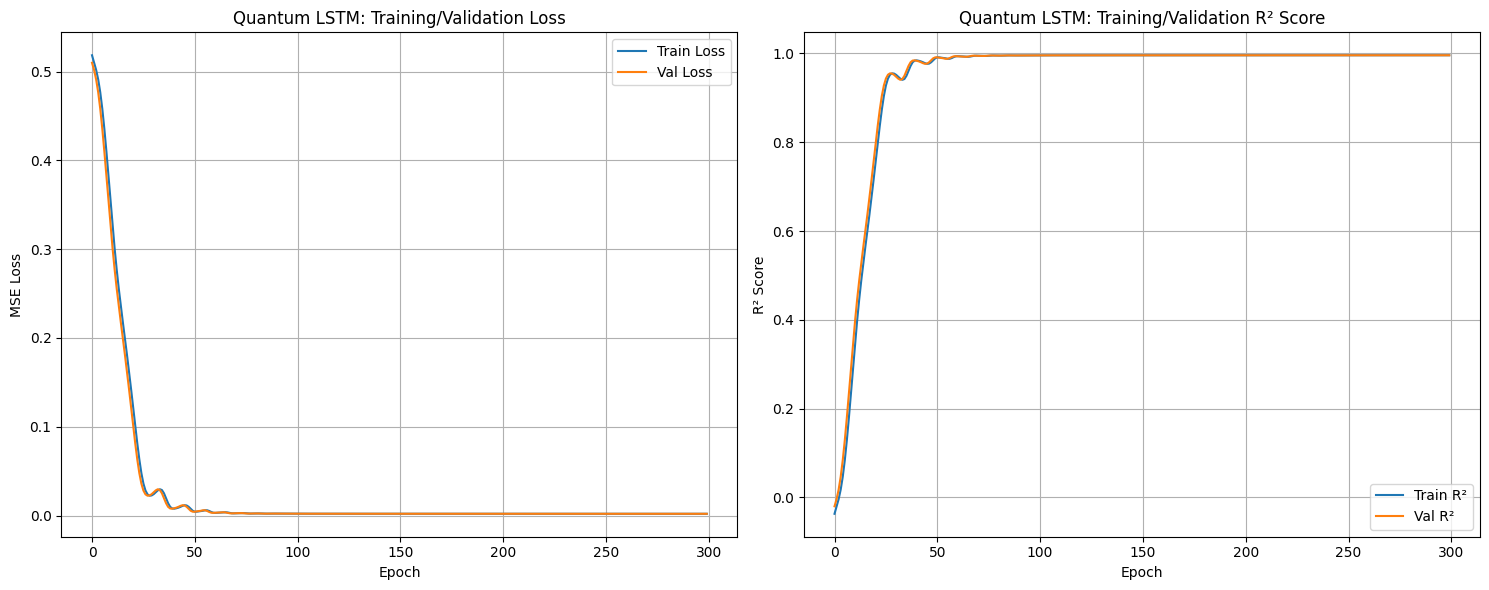

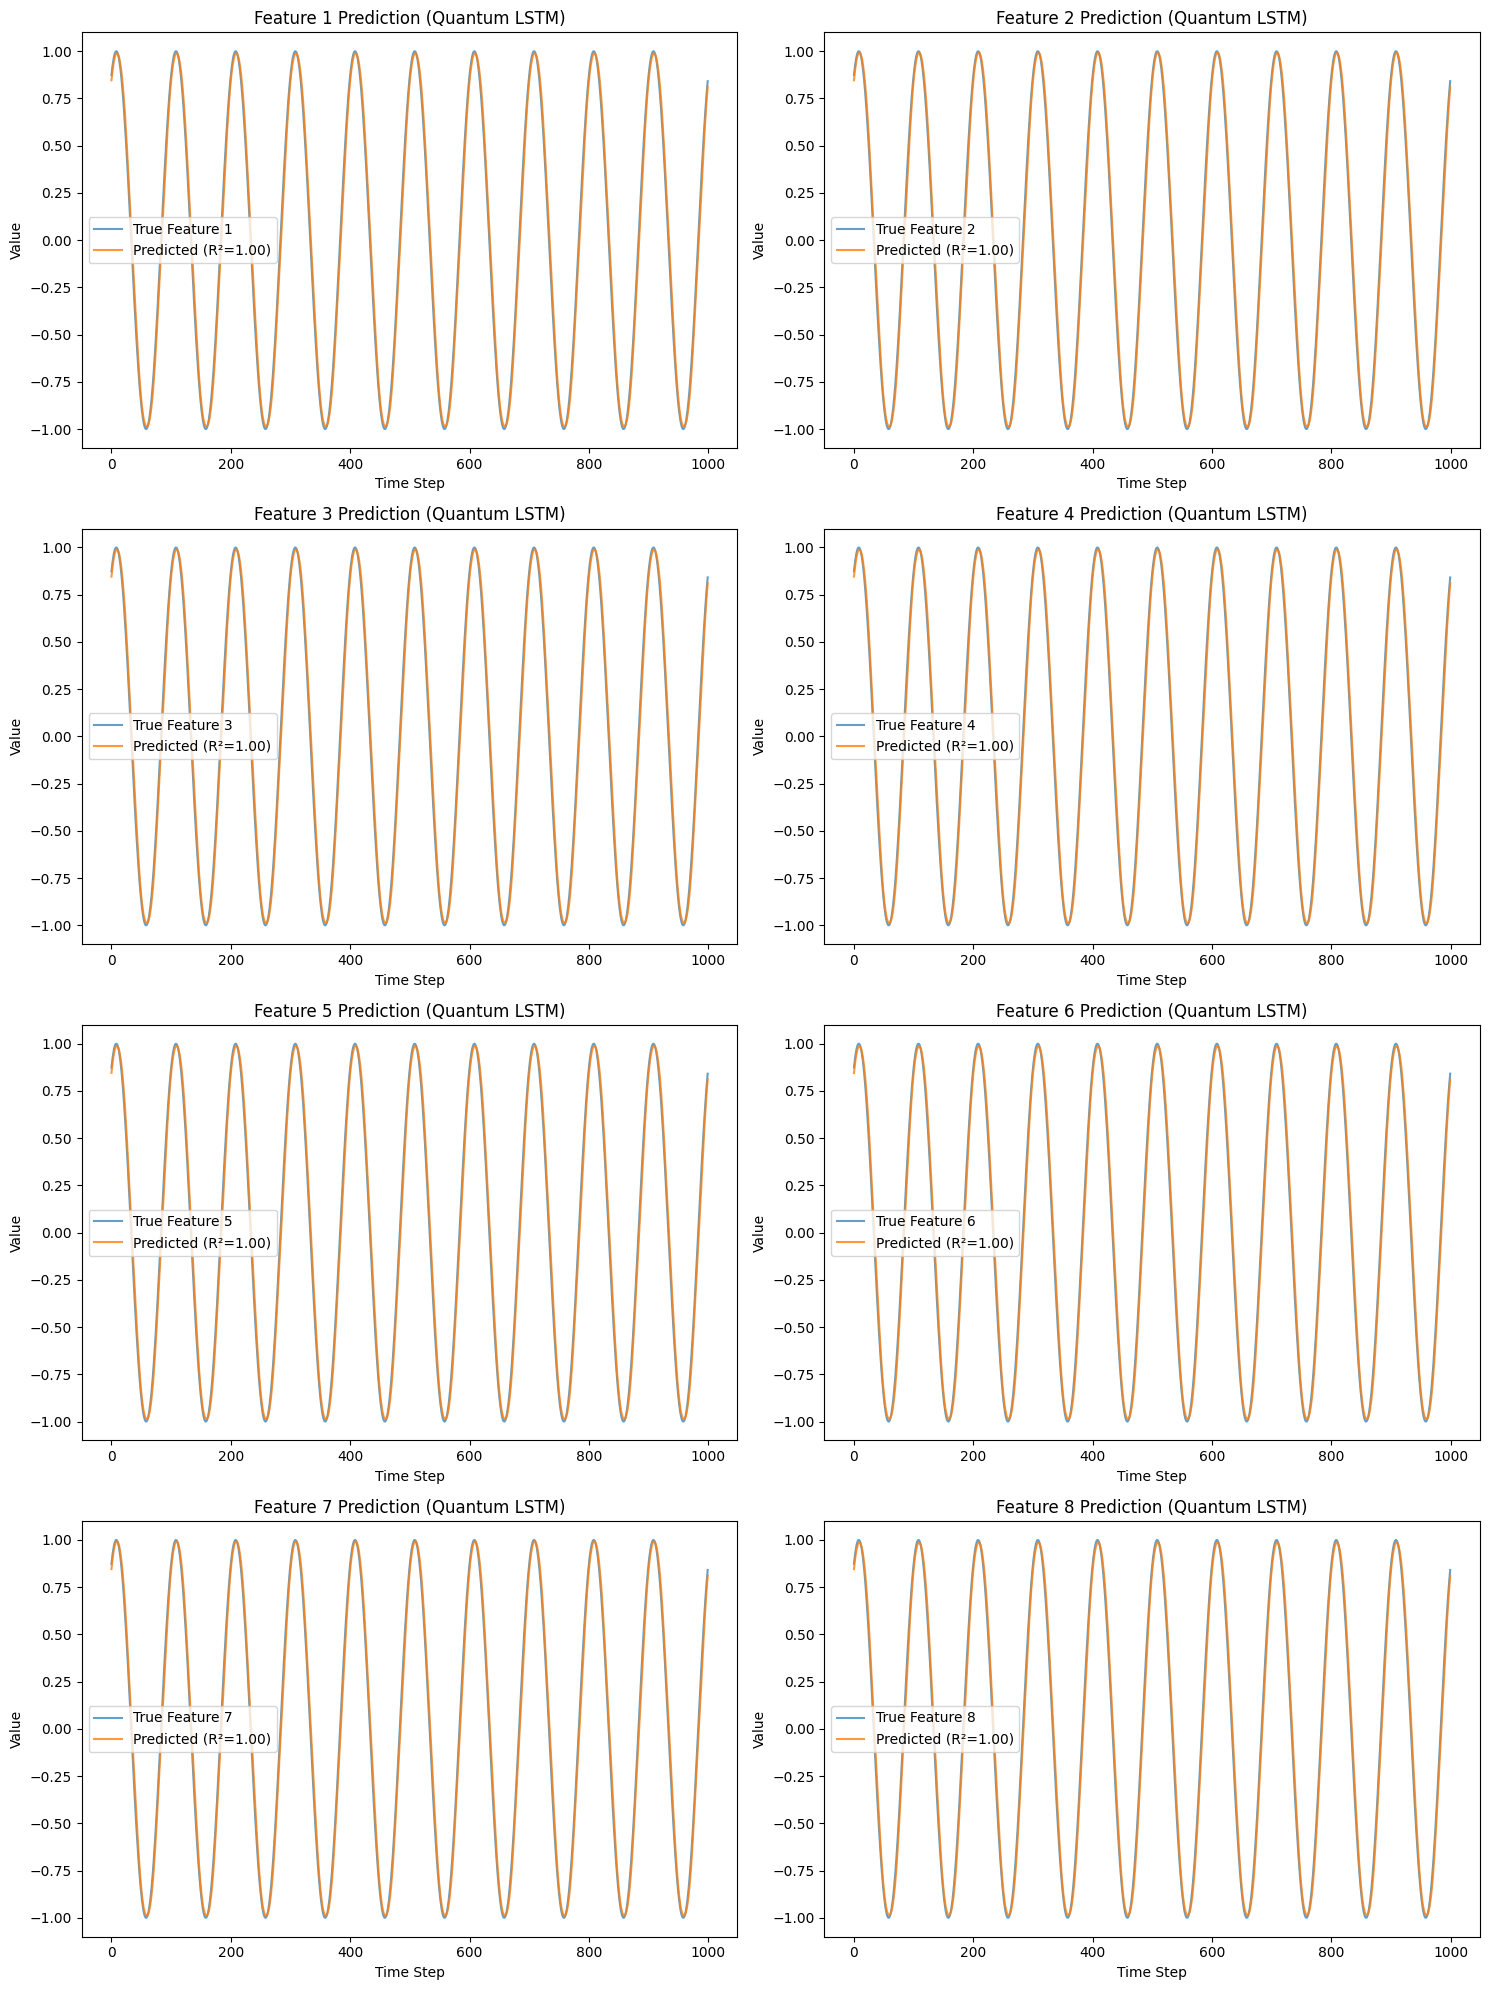


Quantum LSTM - Final Feature-wise Performance:
Feature 1: R² = 0.9960
Feature 2: R² = 0.9960
Feature 3: R² = 0.9960
Feature 4: R² = 0.9960
Feature 5: R² = 0.9960
Feature 6: R² = 0.9960
Feature 7: R² = 0.9960
Feature 8: R² = 0.9960


In [ ]:
from sklearn.metrics import r2_score

# Quantum LSTM parameters
Qinput_dim = 8
Qhidden_dim = 32
Qn_qubits = 8
Qoutput_dim = 8
backend = 'default.qubit'
model = LSTMRegressor(Qinput_dim, Qhidden_dim, output_dim=Qoutput_dim, 
                     n_qubits=Qn_qubits, backend=backend)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop with metrics tracking
num_epochs = 300
train_loss_history = []
val_loss_history = []
train_r2_history = []
val_r2_history = []

# Convert tensors to numpy for metric calculations
y_train_np = y_train_tensor.numpy()
y_test_np = y_test_tensor.numpy()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    train_loss = loss_function(outputs, y_train_tensor)
    
    # Calculate training R²
    train_preds = outputs.detach().numpy()
    train_r2 = r2_score(y_train_np, train_preds, multioutput='uniform_average')
    
    train_loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = loss_function(val_outputs, y_test_tensor)
        val_preds = val_outputs.numpy()
        val_r2 = r2_score(y_test_np, val_preds, multioutput='uniform_average')
    
    # Store metrics
    train_loss_history.append(train_loss.item())
    val_loss_history.append(val_loss.item())
    train_r2_history.append(train_r2)
    val_r2_history.append(val_r2)
    
    # Print epoch statistics
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
# Plot metrics
plt.figure(figsize=(15, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Quantum LSTM: Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# R² plot
plt.subplot(1, 2, 2)
plt.plot(train_r2_history, label='Train R²')
plt.plot(val_r2_history, label='Val R²')
plt.title('Quantum LSTM: Training/Validation R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final feature-wise evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Calculate R² scores for each feature
feature_r2_scores = [r2_score(y_8_test[:, i], y_pred[:, i]) for i in range(8)]

# Plot predictions with individual R² scores
plt.figure(figsize=(15, 20))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.plot(y_8_test[:, i], label=f'True Feature {i+1}', alpha=0.7)
    plt.plot(y_pred[:, i], label=f'Predicted (R²={feature_r2_scores[i]:.2f})', alpha=0.8)
    plt.title(f'Feature {i+1} Prediction (Quantum LSTM)')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

# Print final feature metrics
print("\nQuantum LSTM - Final Feature-wise Performance:")
for i, r2 in enumerate(feature_r2_scores):
    print(f"Feature {i+1}: R² = {r2:.4f}")

Using Classical LSTM
Epoch 10/300 | Train Loss: 9033.1826 | Val Loss: 8571.2148 | Train R²: -247.8915 | Val R²: -4998.6552
Epoch 20/300 | Train Loss: 8828.9922 | Val Loss: 8371.5723 | Train R²: -212.4446 | Val R²: -4262.2077
Epoch 30/300 | Train Loss: 8661.4404 | Val Loss: 8208.1650 | Train R²: -181.7064 | Val R²: -3649.3134
Epoch 40/300 | Train Loss: 8486.8359 | Val Loss: 8046.0405 | Train R²: -151.9443 | Val R²: -3073.7863
Epoch 50/300 | Train Loss: 8323.1504 | Val Loss: 7888.5732 | Train R²: -127.2455 | Val R²: -2570.8020
Epoch 60/300 | Train Loss: 8172.2056 | Val Loss: 7743.8091 | Train R²: -105.7133 | Val R²: -2132.9212
Epoch 70/300 | Train Loss: 8029.5669 | Val Loss: 7607.2144 | Train R²: -87.2377 | Val R²: -1757.9836
Epoch 80/300 | Train Loss: 7894.7661 | Val Loss: 7478.2080 | Train R²: -71.5834 | Val R²: -1440.3440
Epoch 90/300 | Train Loss: 7766.8550 | Val Loss: 7355.8740 | Train R²: -58.3929 | Val R²: -1172.8128
Epoch 100/300 | Train Loss: 7644.9658 | Val Loss: 7239.3999 | Tr

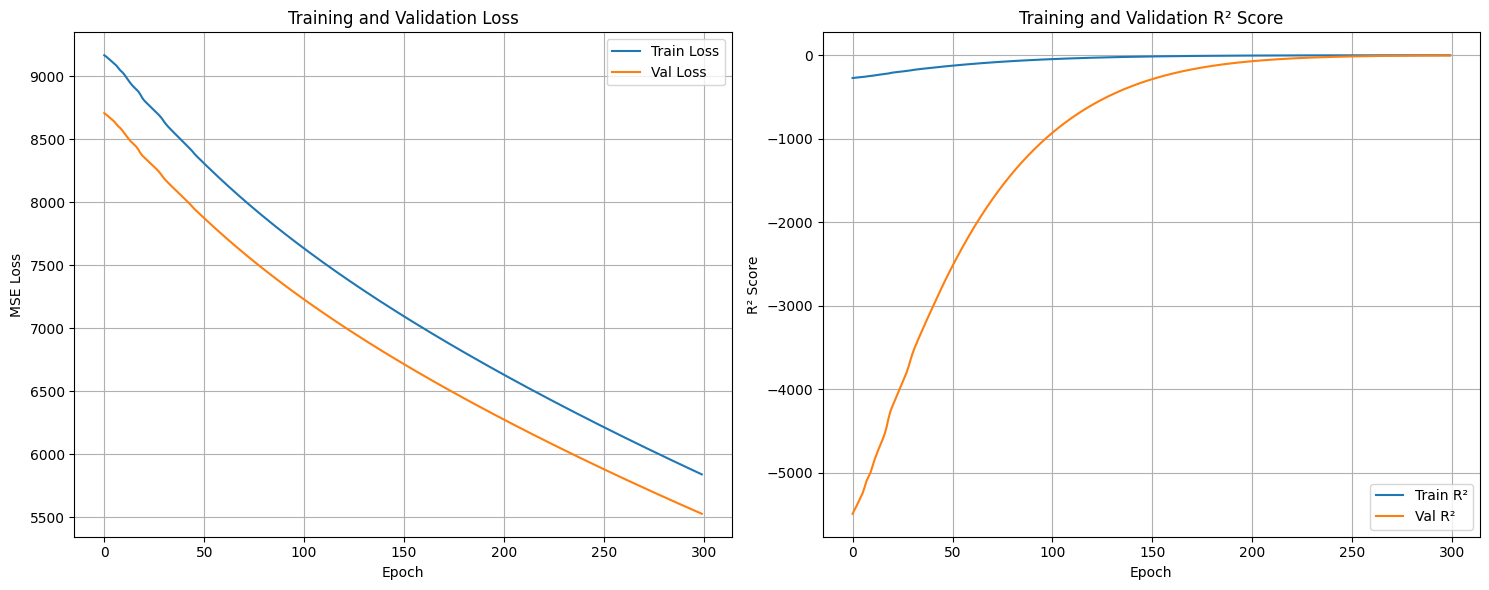

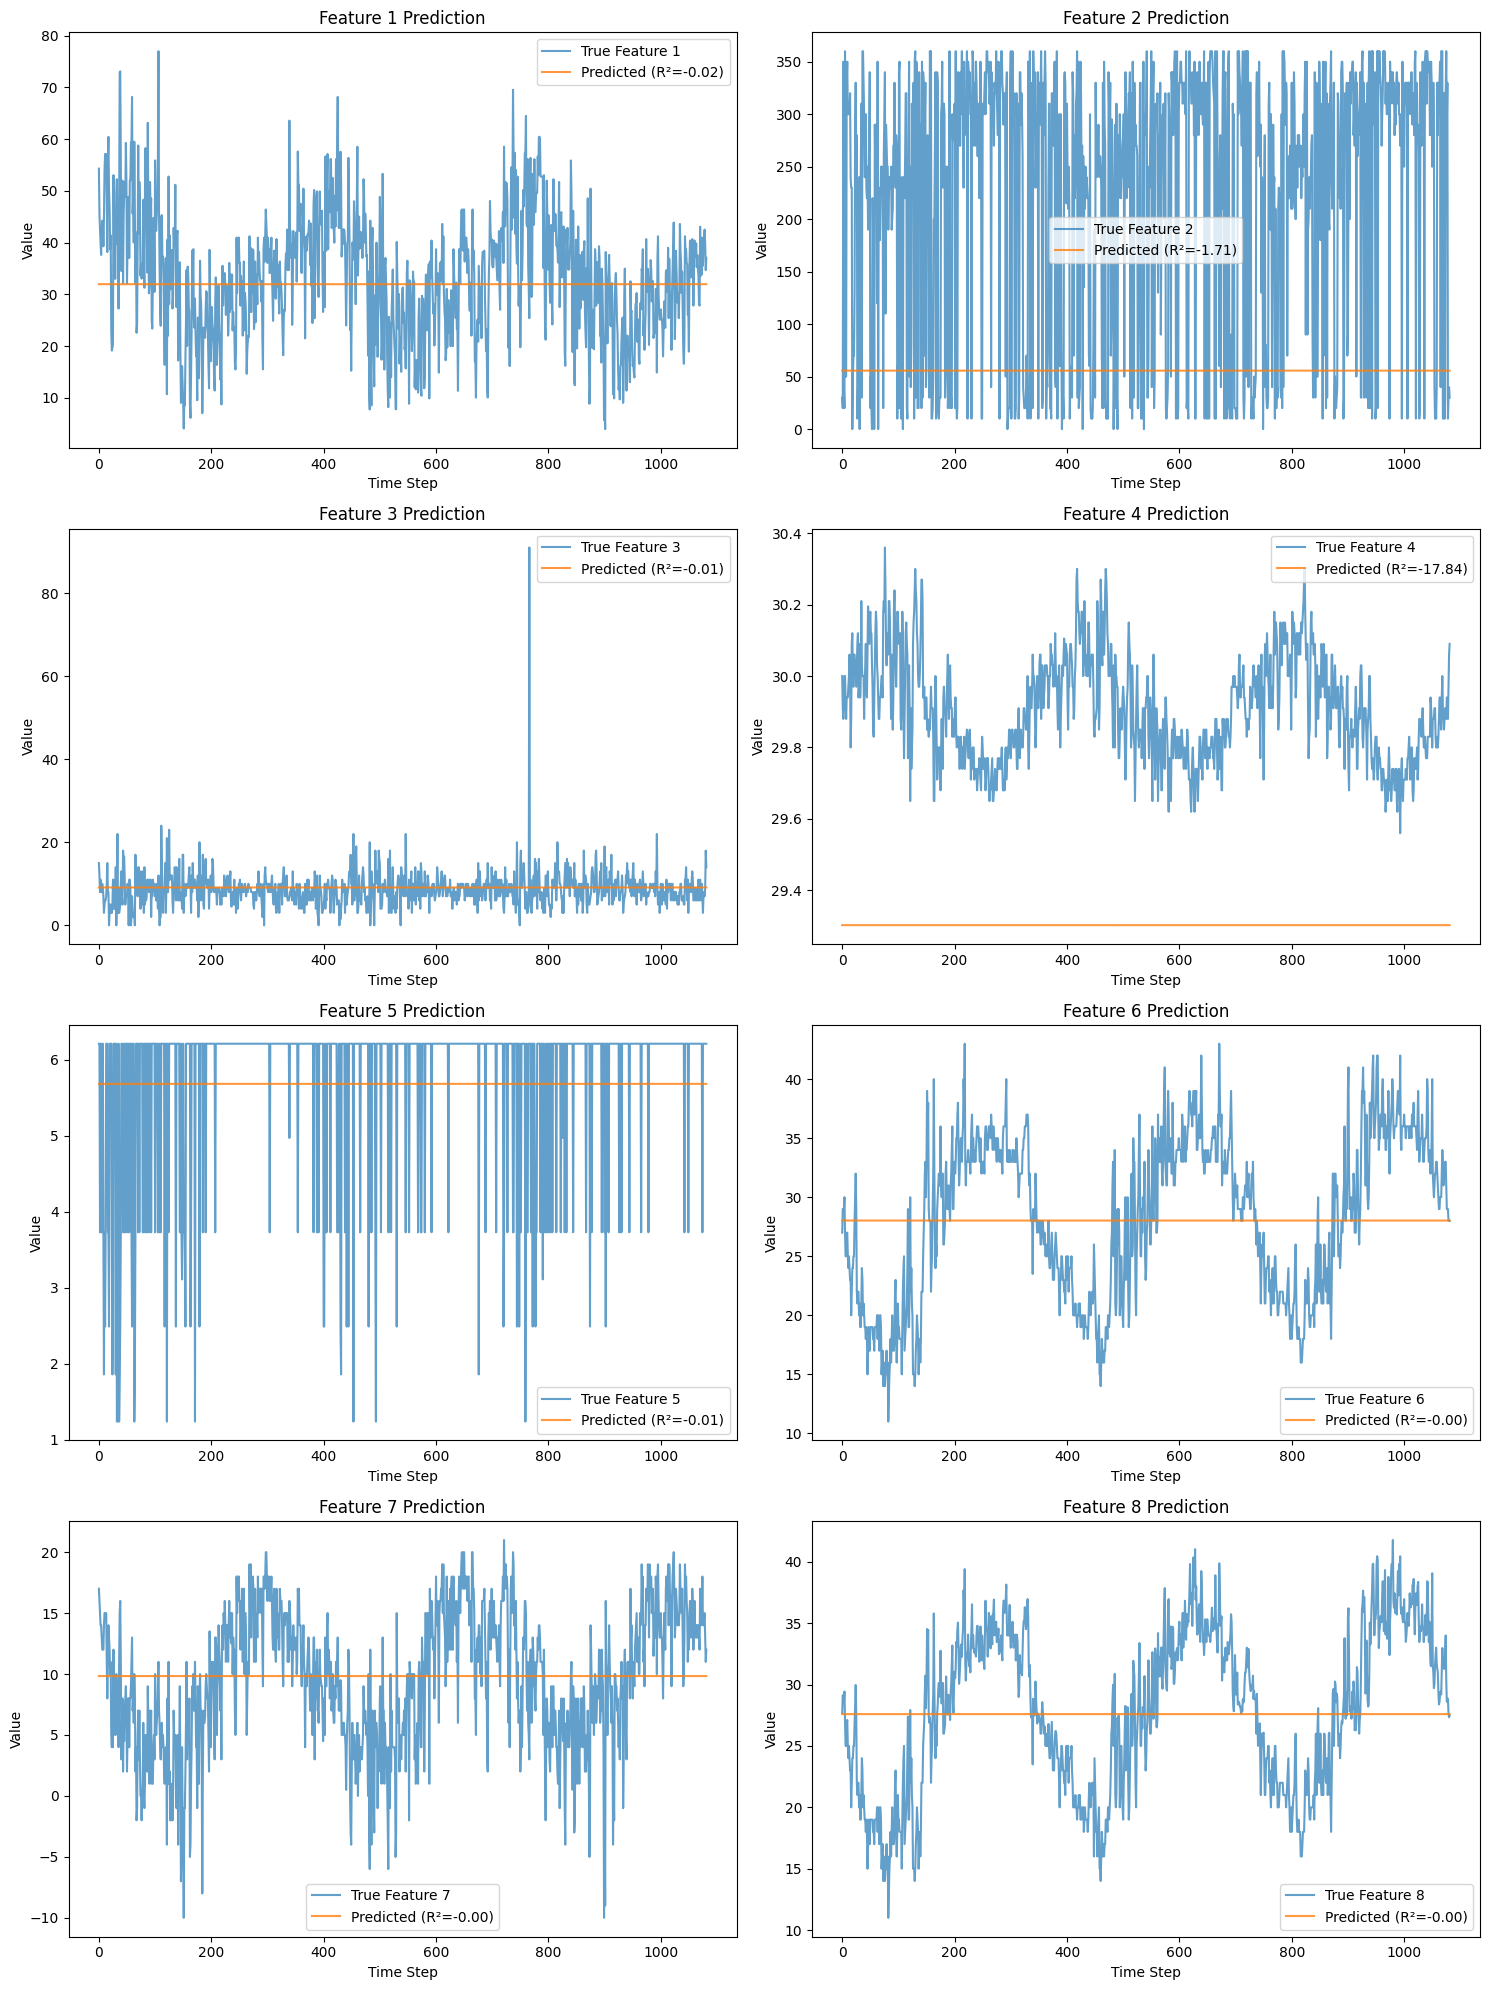


Final Feature-wise Performance:
Feature 1: R² = -0.0152
Feature 2: R² = -1.7134
Feature 3: R² = -0.0125
Feature 4: R² = -17.8361
Feature 5: R² = -0.0087
Feature 6: R² = -0.0020
Feature 7: R² = -0.0023
Feature 8: R² = -0.0017


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Model parameters
Cinput_dim = 8
Chidden_dim = 32
output_dim = 8
backend = 'default.qubit'

# Initialize the model, optimizer, and loss function
model = LSTMRegressor(Cinput_dim, Chidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop with metrics tracking
num_epochs = 300
train_loss_history = []
val_loss_history = []
train_r2_history = []
val_r2_history = []

# Convert tensors to numpy for metric calculations
y_train_np = y_train_tensor.numpy()
y_test_np = y_test_tensor.numpy()

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    train_loss = loss_function(outputs, y_train_tensor)
    
    # Calculate training R²
    train_preds = outputs.detach().numpy()
    train_r2 = r2_score(y_train_np, train_preds, multioutput='uniform_average')
    
    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = loss_function(val_outputs, y_test_tensor)
        val_preds = val_outputs.numpy()
        val_r2 = r2_score(y_test_np, val_preds, multioutput='uniform_average')
    
    # Store metrics
    train_loss_history.append(train_loss.item())
    val_loss_history.append(val_loss.item())
    train_r2_history.append(train_r2)
    val_r2_history.append(val_r2)
    
    # Print epoch statistics
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} | "
              f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")

# Plot metrics
plt.figure(figsize=(15, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# R² plot
plt.subplot(1, 2, 2)
plt.plot(train_r2_history, label='Train R²')
plt.plot(val_r2_history, label='Val R²')
plt.title('Training and Validation R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final feature-wise evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Calculate R² scores for each feature
feature_r2_scores = [r2_score(y_test_np[:, i], y_pred[:, i]) for i in range(output_dim)]

# Plot predictions with individual R² scores
plt.figure(figsize=(15, 20))
for i in range(output_dim):
    plt.subplot(4, 2, i+1)
    plt.plot(y_test_np[:, i], label=f'True Feature {i+1}', alpha=0.7)
    plt.plot(y_pred[:, i], label=f'Predicted (R²={feature_r2_scores[i]:.2f})', alpha=0.8)
    plt.title(f'Feature {i+1} Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

# Print final feature metrics
print("\nFinal Feature-wise Performance:")
for i, r2 in enumerate(feature_r2_scores):
    print(f"Feature {i+1}: R² = {r2:.4f}")